In [1100]:
import random
import warnings

import lightgbm as lgbm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from lightgbm import early_stopping
from lightgbm import log_evaluation
from lightgbm import record_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

np.random.seed(42)
random.seed(42)
from lightgbm import LGBMRegressor
import optuna
from optuna.study import StudyDirection
import mlflow

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import shap

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 400)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import re

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import SpectralClustering

In [1101]:
df = pd.read_csv('./all_data.csv')
df = df.dropna(subset=['Количество комнат', 'Площадь общая', 'Площадь жилая'])
df = df.where(pd.notna(df), None)
df.reset_index(drop=True, inplace=True)
df

,ID,Price,Количество комнат,Раздельных комнат,Площадь общая,Площадь жилая,Площадь кухни,Год постройки,Тип дома,Планировка,Балкон,Новостройка,Ремонт,Стоянка автомобиля,Собственность,Условия продажи,Номер договора,Область,Улица,Район города,Микрорайон,Координаты,Санузел,Район,Номер дома,Площадь по СНБ,Возможен торг,Высота потолков,Площадь балконов,Полы,Мебель,Видео-домофон,Телефон,Огороженная территория,Гараж,Вид этажа,Сигнализация,Год капитального ремонта,Жилой комплекс,Варианты обмена,Сельсовет,Направление,Число уровней,Аукцион,Частная,Тип населного пункта,Населеный пункт,Этаж квартиры,Всего этажей,set_type
0,2806428,33700.0,1.0,1.0,30.00,16.00,7.00,2027.0,Каркасно-блочный,Свободная планировка,Лоджия,Да,Без отделки,Есть,Частная,Чистая продажа,1/1 от 04.01.2022,Минская область,Мира просп.,Октябрьский район,Минск Мир (Minsk World),"53.8637, 27.542404",None,None,None,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Минск,11.0,15.0,train
1,3216141,79000.0,3.0,3.0,61.00,39.70,8.20,1986.0,Кирпичный,None,Лоджия застекленная,None,Евроремонт,None,Частная,Чистая продажа,23418,Брестская область,Машерова просп.,Ленинский район,Центр,"52.086084, 23.691745",Раздельный,Брестский район,None,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Брест,9.0,9.0,train
2,3264122,43500.0,2.0,2.0,45.10,26.50,6.50,1992.0,Кирпичный,None,Лоджия застекленная,None,None,None,Частная,Чистая продажа,24040,Брестская область,Дубровская ул.,Ленинский район,Дубровка,"52.133375, 23.650548",Раздельный,Брестский район,None,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Брест,5.0,5.0,train
3,2562548,92874.0,2.0,2.0,67.30,65.10,NaN,NaN,Каркасно-блочный,None,Балкон,None,None,None,Частная,Чистая продажа,None,Минская область,Ильянская ул.,Центральный район,Лебяжий (Ржавец),"53.93437, 27.469058",None,None,12,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Минск,4.0,10.0,train
4,3229926,46500.0,3.0,3.0,49.20,33.90,5.30,1973.0,Панельный,None,Балкон,None,None,None,Частная,Обмен,75/1 от 15.01.2024,Брестская область,Партизанский просп.,Московский район,Восток,"52.106411, 23.760331",None,Брестский район,None,51.6,Да,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Брест,5.0,5.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21124,3212250,40200.0,2.0,2.0,43.80,30.90,5.80,1967.0,Кирпичный,Стандартный проект,None,None,Хороший,None,None,Чистая продажа,380057 от 15.12.2023,Брестская область,Карбышева ул.,Ленинский район,Центр,"52.096614, 23.694638",None,Брестский район,38,43.8,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Брест,1.0,5.0,test
21125,3254049,48000.0,3.0,3.0,72.00,43.10,9.40,2008.0,Панельный,Улучшенный проект,Лоджия застекленная,None,Отличный,None,Частная,Чистая продажа,32/3 от 13.02.2024,Витебская область,Молодежная ул.,None,None,"55.506249, 28.69934",Раздельный,Полоцкий район,186/1,NaN,None,NaN,2.5,Ламинированные,None,None,Есть,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Новополоцк,1.0,9.0,test
21126,2955726,74000.0,2.0,2.0,50.50,30.90,7.20,1980.0,Панельный,None,Лоджия застекленная,None,Хороший,None,Частная,Чистая продажа,259/1 от 07.11.2023,Минская область,Шишкина ул.,Заводской район,Р-н ДК МАЗ,"53.86161, 27.631001",Раздельный,None,20/4,NaN,None,2.50,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,None,None,г.,Минск,2.0,12.0,train
21127,3212243,45000.0,4.0,4.0,74.22,50.97,7.59,1988.0,Кирпичный,None,2 лоджии,None,None,None,Частная,Чистая продажа,26/21 от 15.12.2023,Гомельская область,17-й м-н,None,None,"52.892256, 30.037813",Раздельный,Жлобинский район,15,NaN,None,2.57,NaN,None,None,None,Non

In [1102]:
df = df.rename(columns={'Населеный пункт': 'Населенный пункт', 'Тип населного пункта': 'Тип населенного пункта'})

## Исправление косячных строк

In [1103]:
df.loc[df['ID'] == 3164204, ['Варианты обмена', 'Возможен торг', 'Собственность', 'Условия продажи']] = [np.nan, 'Да', 'Частная', 'Чистая продажа']

In [1104]:
df.loc[df['ID'] == 3235698, ['Район']] = ['Витебский район']

In [1105]:
df.loc[df['ID'] == 2910603, ['Price']] = 69900

In [1106]:
df.loc[df['ID'] == 3244152, ['Price']] = 97000

# Feature engineering

## Часть 1 гео и прочие фичи

In [1107]:
geo_and_other_features =['ID', 'Область', 'Улица', 'Район города', 'Микрорайон', 'Координаты', 'Район', 'Номер дома', 'Сельсовет', 'Направление','Тип населенного пункта', 'Населенный пункт', 'Собственность', 'Условия продажи',
       'Номер договора','Возможен торг', 'Варианты обмена', 'Аукцион', 'Частная']

<Axes: >

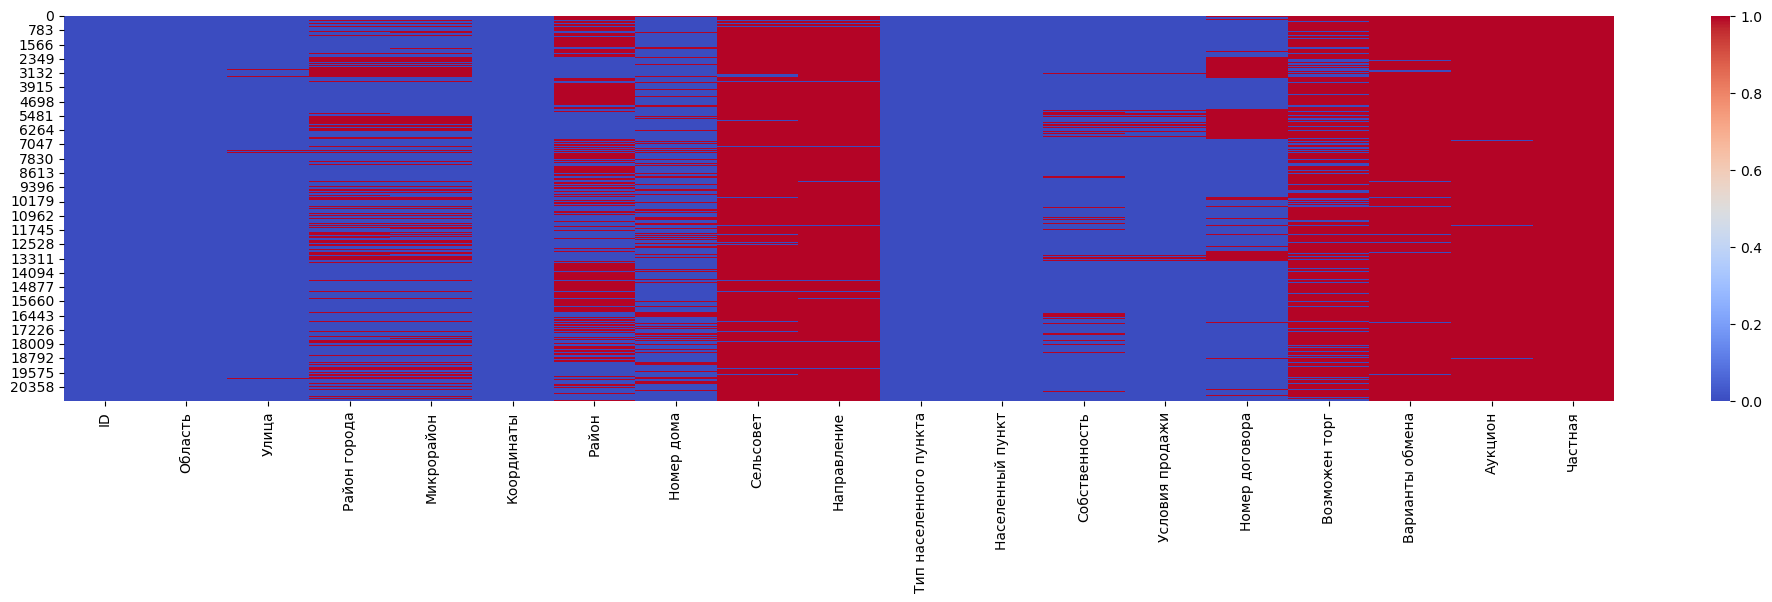

In [1108]:
plt.figure(figsize=(25, 5))
sns.heatmap(df[geo_and_other_features].isna(), cmap='coolwarm')

In [1109]:
df[geo_and_other_features]

,ID,Область,Улица,Район города,Микрорайон,Координаты,Район,Номер дома,Сельсовет,Направление,Тип населенного пункта,Населенный пункт,Собственность,Условия продажи,Номер договора,Возможен торг,Варианты обмена,Аукцион,Частная
0,2806428,Минская область,Мира просп.,Октябрьский район,Минск Мир (Minsk World),"53.8637, 27.542404",None,None,None,None,г.,Минск,Частная,Чистая продажа,1/1 от 04.01.2022,None,None,None,None
1,3216141,Брестская область,Машерова просп.,Ленинский район,Центр,"52.086084, 23.691745",Брестский район,None,None,None,г.,Брест,Частная,Чистая продажа,23418,None,None,None,None
2,3264122,Брестская область,Дубровская ул.,Ленинский район,Дубровка,"52.133375, 23.650548",Брестский район,None,None,None,г.,Брест,Частная,Чистая продажа,24040,None,None,None,None
3,2562548,Минская область,Ильянская ул.,Центральный район,Лебяжий (Ржавец),"53.93437, 27.469058",None,12,None,None,г.,Минск,Частная,Чистая продажа,None,None,None,None,None
4,3229926,Брестская область,Партизанский просп.,Московский район,Восток,"52.106411, 23.760331",Брестский район,None,None,None,г.,Брест,Частная,Обмен,75/1 от 15.01.2024,Да,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21124,3212250,Брестская область,Карбышева ул.,Ленинский район,Центр,"52.096614, 23.694638",Брестский район,38,None,None,г.,Брест,None,Чистая продажа,380057 от 15.12.2023,None,None,None,None
21125,3254049,Витебская область,Молодежная ул.,None,None,"55.506249, 28.69934",Полоцкий район,186/1,None,None,г.,Новополоцк,Частная,Чистая продажа,32/3 от 13.02.2024,None,None,None,None
21126,2955726,Минская область,Шишкина ул.,Заводской район,Р-н ДК МАЗ,"53.86161, 27.631001",None,20/4,None,None,г.,Минск,Частная,Чистая продажа,259/1 от 07.11.2023,None,None,None,None
21127,3212243,Гомельская область,17-й м-н,None,None,"52.892256, 30.037813",Жлобинский район,15,None,None,г.,Жлобин,Частная,Чистая продажа,26/21 от 15.12.2023,None,None,None,None


In [1110]:
df['Область'] = df['Область'].apply(lambda x: ' '.join(x.split()[:-1]))
df['Область'] = df.apply(lambda x: 'Минск' if x['Населенный пункт'] == 'Минск' else x['Область'], axis=1)

In [1111]:
df['Область'].value_counts(dropna=False) # пропусков нет, кодировка OHE

Область
Минск          10030
Брестская       3877
Минская         2105
Витебская       1453
Гродненская     1384
Гомельская      1364
Могилевская      916
Name: count, dtype: int64

In [1112]:
df['Район'] = df.apply(lambda x: 'Минск' if x['Населенный пункт'] == 'Минск' else x['Район'], axis=1)
df['Район'] = df['Район'].str.replace('район', '')

In [1113]:
df['Район'].value_counts(dropna=False) # пропусков нет, кодировка OHE

Район
Минск              10030
Брестский           2597
Гродненский          796
Минский              761
Гомельский           720
                   ...  
Наровлянский           1
Зельвенский            1
Чечерский              1
Краснопольский         1
Хотимский              1
Name: count, Length: 117, dtype: int64

In [1114]:
df['Район города'] = df.apply(lambda x: 'Missing' if x['Тип населенного пункта'] != 'г.' else x['Район города'], axis=1)
df['Район города'] = df.apply(lambda x: 'Missing' if x['Населенный пункт'] not in ['Минск', 'Брест', 'Витебск', 'Гомель', 'Гродно', 'Могилев'] else x['Район города'], axis=1)
df['Район города'] = df['Район города'].str.replace('район', '')

In [1115]:
df['Район города'].value_counts(dropna=False) # 229 пропусков, но сложно восстановить кодировка OHE

Район города
Октябрьский         6541
Missing             6024
Московский          2671
Ленинский           1744
Центральный         1295
Первомайский        1028
Фрунзенский          532
Советский            412
Железнодорожный      259
None                 221
Партизанский         173
Заводской            161
Новобелицкий          68
Name: count, dtype: int64

In [1116]:
# coordinates = df['Координаты'][df['Район города'].isna()].unique().tolist()

In [1117]:
# with open('coordinates_2.txt', 'w') as file:
#     for item in coordinates:
#         file.write(str(item) + '\n')

In [1118]:
df['Микрорайон'] = df.apply(lambda x: 'Missing' if x['Тип населенного пункта'] != 'г.' else x['Микрорайон'], axis=1)
df['Микрорайон'] = df.apply(lambda x: 'Missing' if x['Населенный пункт'] not in ['Минск', 'Брест', 'Витебск', 'Гомель', 'Гродно', 'Могилев'] else x['Микрорайон'], axis=1)

In [1119]:
value_counts = df['Микрорайон'].value_counts()
microdistricts_to_replace = value_counts[value_counts <=10].index
df.loc[df['Микрорайон'].isin(microdistricts_to_replace), 'Микрорайон'] = 'Другой'

In [1120]:
df['Микрорайон'].value_counts(dropna=False) # 407 пропусков, но сложно восстановить кодировка OHE, убрала редковствечающиеся микрорайоны

Микрорайон
Missing                             6024
Минск Мир (Minsk World)             5536
Центр                                903
Дзержинского, Хмелевского, Щорса     606
Левада                               506
                                    ... 
Заднепровье-4                         12
Вычулки                               11
Себяхи                                11
30 лет Победы                         11
Давыдовка                             11
Name: count, Length: 138, dtype: int64

In [1121]:
def find_street_type(x):
    if isinstance(x, str):
        street_types = ['ул', 'ул', 'Ул', 'Проспект', 'просп', 'Пр', 'пер', 'Пер', 'Аллея', 'тракт', 'ш', 'наб', 'проезд', 'б-р', 'бульвар']
        match = re.search(r'\b(?:' + '|'.join(street_types) + r')\.?\b', x)
        return match.group(0) if match else np.nan
    else:
        return np.nan

# Применение функции к столбцу "Улица"
df['Тип улицы'] = df['Улица'].apply(lambda x: find_street_type(x))

replace_dict = {
    'Ул': 'ул',
    'ул.': 'ул',
    'Проспект': 'просп',
    'Пр.': 'просп',
    'бульвар': 'б-р',
    'Пер.': 'пер',
    'Пер': 'пер',
    'Аллея': 'аллея'}

# Заменяем значения с помощью словаря
df['Тип улицы'] = df['Тип улицы'].replace(replace_dict, regex=True)

In [1122]:
df['Тип улицы'].value_counts(dropna=False) # 660 пропусков, но сложно восстановить кодировка OHE

Тип улицы
ул        16300
просп      3474
NaN         650
пер         400
б-р         174
тракт        35
ш            28
проезд       24
наб          23
булвар       11
аллея        10
Name: count, dtype: int64

In [1123]:
df['Собственность'] = df['Собственность'].apply(lambda x: 'Частная' if pd.isna(x) else x)

In [1124]:
df['Условия продажи'] = df['Условия продажи'].apply(lambda x: 'Чистая продажа' if pd.isna(x) else x)
df['Условия продажи'] = df['Условия продажи'].apply(lambda x:  'Обмен' if x in ['Обмен - разъезд', 'Обмен - съезд'] else x)

In [1125]:
df['Условия продажи'].value_counts(dropna=False)


Условия продажи
Чистая продажа          20250
Обмен                     502
Подбираются варианты      377
Name: count, dtype: int64

In [1126]:
df['Аукцион'] = df['Аукцион'].apply(lambda x: 0 if pd.isna(x) else 1)

In [1127]:
df['Аукцион'].value_counts(dropna=False)

Аукцион
0    21091
1       38
Name: count, dtype: int64

In [1128]:
df['Продавец'] = df.apply(lambda x: 0 if pd.isna(x['Номер договора']) else 1, axis=1)

In [1129]:
df['Продавец'].value_counts(dropna=False)

Продавец
1    16899
0     4230
Name: count, dtype: int64

In [1130]:
mask = ~df['Тип населенного пункта'].isin(['г.', 'аг.', 'г.п.', 'к.п.', 'р.п.', 'п.', 'д.'])
df.loc[mask, 'Населенный пункт'] = np.nan

In [1131]:
df['Населенный пункт'].value_counts(dropna=False)

Населенный пункт
Минск        10030
Брест         2530
Гродно         769
Гомель         667
Витебск        656
             ...  
Пристромы        1
Тимковичи        1
Носовичи         1
Камено           1
Турец            1
Name: count, Length: 595, dtype: int64

In [1132]:
mask = ~df['Тип населенного пункта'].isin(['г.', 'аг.', 'г.п.', 'к.п.', 'р.п.', 'п.', 'д.'])
df.loc[mask, 'Тип населенного пункта'] = np.nan

In [1133]:
df['Тип населенного пункта'].value_counts(dropna=False)

Тип населенного пункта
г.      19329
д.        757
аг.       640
г.п.      226
п.        127
NaN        32
р.п.       12
к.п.        6
Name: count, dtype: int64

In [1134]:
df['Тип населенного пункта'] = df['Тип населенного пункта'].map({
    'г.' : 8,
    'аг.': 7,
    'г.п.': 6,
    'к.п.': 5,
    'р.п.': 4,
    'п.': 3,
    'д.': 1,
    np.nan: 0})

In [1135]:
# df[~df['Тип населенного пункта'].isin(['г.', 'аг.', 'г.п.', 'к.п.', 'р.п.', 'п.', 'д.'])]

In [1136]:
df['Широта'] = df['Координаты'].apply(lambda x: x.split(',')[0]).astype(float)
df['Долгота'] = df['Координаты'].apply(lambda x: x.split(',')[1]).astype(float)

In [1137]:
from math import radians, sin, cos, sqrt, atan2

coordinates_big_townd = {'Минская': [53.902284, 27.561831],
  'Минск': [53.902284, 27.561831],
  'Брестская': [52.093754, 23.685107], 
  'Витебская': [55.184217, 30.202878], 
  'Гомельская': [52.435159, 31.019465], 
  'Гродненская': [53.677839, 23.829529], 
  'Могилевская': [53.894548, 30.330654]}

df['Широта_обл_город'] = df['Область'].map(lambda x: coordinates_big_townd[x][0]).astype(float)
df['Долгота_обл_город'] = df['Область'].map(lambda x: coordinates_big_townd[x][1]).astype(float)

def haversine(lat1, lon1, lat2, lon2):
    # Радиус Земли в км
    R = 6371.0
    
    # Преобразование координат в радианы
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    # Разница между широтами и долготами
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Формула Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Расстояние между двумя точками
    distance = R * c
    
    return distance

df['Дистанция до обл. центра'] = df.apply(lambda x: haversine(x['Широта'], x['Долгота'], x['Широта_обл_город'], x['Долгота_обл_город']), axis = 1)

In [1138]:
from math import radians, sin, cos, sqrt, atan2

coordinates_big_townd = {'Минская': [53.902284, 27.561831],
  'Минск': [53.902284, 27.561831],
  'Брестская': [52.093754, 23.685107], 
  'Витебская': [55.184217, 30.202878], 
  'Гомельская': [52.435159, 31.019465], 
  'Гродненская': [53.677839, 23.829529], 
  'Могилевская': [53.894548, 30.330654]}

df['Широта_обл_город'] = df['Область'].map(lambda x: coordinates_big_townd[x][0]).astype(float)
df['Долгота_обл_город'] = df['Область'].map(lambda x: coordinates_big_townd[x][1]).astype(float)

def haversine(lat1, lon1, lat2, lon2):
    # Радиус Земли в км
    R = 6371.0
    
    # Преобразование координат в радианы
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    # Разница между широтами и долготами
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Формула Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Расстояние между двумя точками
    distance = R * c
    
    return distance

df['Дистанция до центра Минска'] = df.apply(lambda x: haversine(x['Широта'], x['Долгота'], 53.902284, 27.561831), axis = 1)

## Часть 2 Технические фичи

In [1139]:
tech_features = ['ID', 'Количество комнат', 'Раздельных комнат',
       'Площадь общая', 'Площадь жилая', 'Площадь кухни', 'Год постройки',
       'Тип дома', 'Планировка', 'Балкон', 'Новостройка', 'Ремонт',
       'Стоянка автомобиля', 'Санузел', 'Площадь по СНБ',
       'Высота потолков', 'Площадь балконов', 'Полы',
       'Мебель', 'Видео-домофон', 'Телефон', 'Огороженная территория', 'Гараж',
       'Вид этажа', 'Сигнализация', 'Год капитального ремонта']

<Axes: >

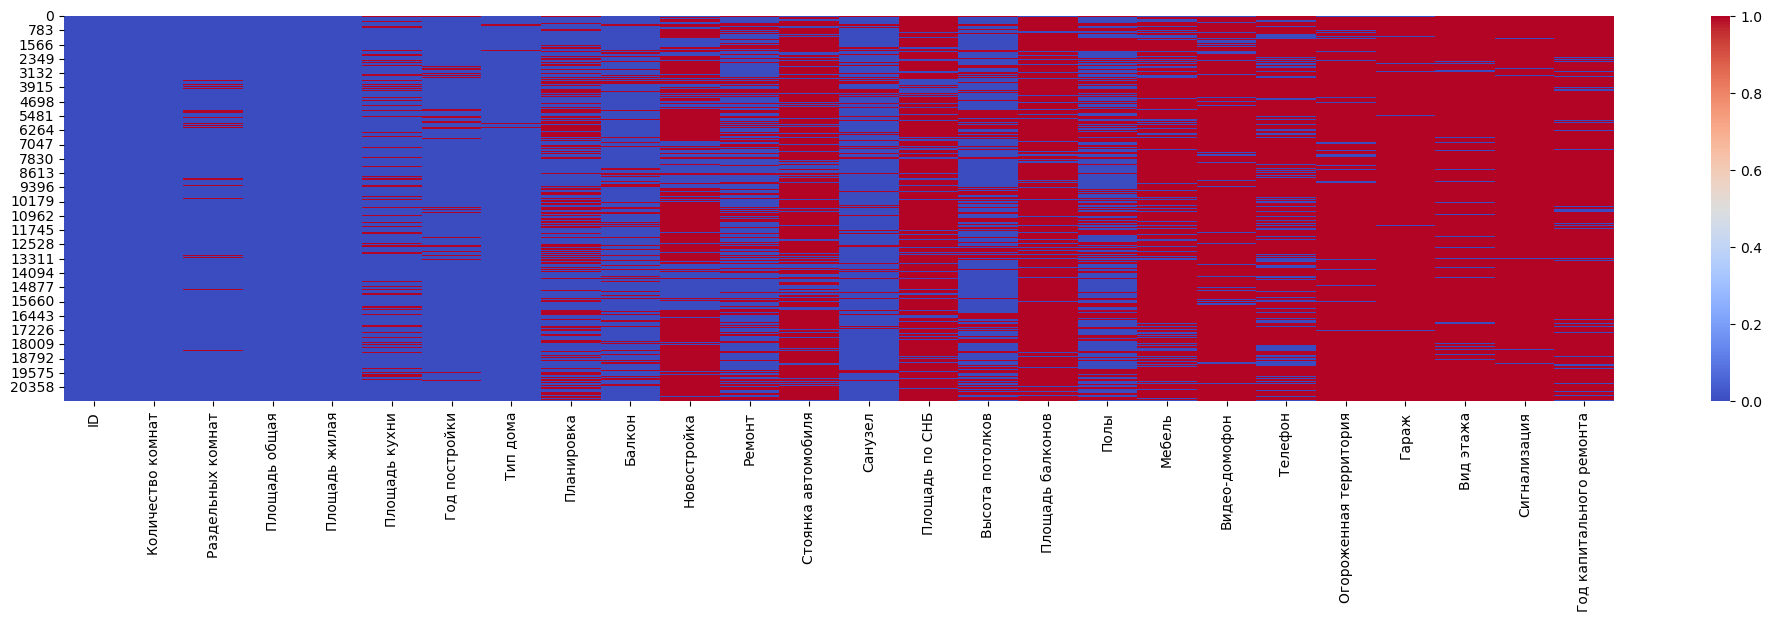

In [1140]:
plt.figure(figsize=(25, 5))
sns.heatmap(df[tech_features].isna(), cmap='coolwarm')

In [1141]:
df[['Новостройка', 'Год постройки']][(df['Год постройки'] > 2022) & (df['Новостройка'].isna())]

,Новостройка,Год постройки
77,None,2023.0
92,None,2023.0
105,None,2023.0
145,None,2024.0
146,None,2023.0
...,...,...
20722,None,2024.0
20785,None,2023.0
20880,None,2023.0
20934,None,2023.0


In [1142]:
df['Раздельных комнат'] = df['Раздельных комнат'].fillna(df['Количество комнат'])

In [1143]:
df['Площадь кухни'] = df['Площадь кухни'].fillna(df['Площадь кухни'].mean())

In [1144]:
df['Балкон'] = df['Балкон'].fillna('unknow')

In [1145]:
df['Площадь балконов'] = df.apply(lambda x: x['Площадь по СНБ'] - x['Площадь общая'] if pd.isna(x['Площадь балконов']) else x['Площадь балконов'], axis=1)
df['Площадь балконов'] = df.apply(lambda x: 0 if (x['Балкон'] == 'unknow') | (x['Балкон'] == 'Эркер') else x['Площадь балконов'], axis=1)

In [1146]:
df['Балкон'] = df.apply(lambda x: 'Терраса' if (x['Балкон'] == 'unknow') & (x['Площадь балконов'] > 0) & (x['Всего этажей'] == 1) else x['Балкон'], axis=1)
df['Балкон'] = df.apply(lambda x: 'Терраса' if (x['Балкон'] == 'unknow') & (x['Площадь балконов'] > 0) & (x['Всего этажей'] == 2) & (x['Площадь балконов'] >=5) else  x['Балкон'], axis=1)
df['Балкон'] = df.apply(lambda x: 'Балкон' if (x['Балкон'] == 'unknow') & (x['Площадь балконов'] > 0) & (x['Всего этажей'] == 2) & (x['Площадь балконов'] <=5) else  x['Балкон'], axis=1)
df['Балкон'] = df.apply(lambda x: 'Терраса' if (x['Балкон'] == 'unknow') & (x['Площадь балконов'] > 0) & (x['Всего этажей'] > 2) & (x['Площадь балконов'] >=3) else  x['Балкон'], axis=1)
df['Балкон'] = df.apply(lambda x: 'Лоджия' if (x['Балкон'] == 'unknow') & (x['Площадь балконов'] > 0) & (x['Всего этажей'] > 2) & (x['Площадь балконов'] <=3) else  x['Балкон'], axis=1)

In [1147]:
df[df['Площадь балконов'].isna()]

,ID,Price,Количество комнат,Раздельных комнат,Площадь общая,Площадь жилая,Площадь кухни,Год постройки,Тип дома,Планировка,Балкон,Новостройка,Ремонт,Стоянка автомобиля,Собственность,Условия продажи,Номер договора,Область,Улица,Район города,Микрорайон,Координаты,Санузел,Район,Номер дома,Площадь по СНБ,Возможен торг,Высота потолков,Площадь балконов,Полы,Мебель,Видео-домофон,Телефон,Огороженная территория,Гараж,Вид этажа,Сигнализация,Год капитального ремонта,Жилой комплекс,Варианты обмена,Сельсовет,Направление,Число уровней,Аукцион,Частная,Тип населенного пункта,Населенный пункт,Этаж квартиры,Всего этажей,set_type,Тип улицы,Продавец,Широта,Долгота,Широта_обл_город,Долгота_обл_город,Дистанция до обл. центра,Дистанция до центра Минска
0,2806428,33700.0,1.0,1.0,30.00,16.00,7.000000,2027.0,Каркасно-блочный,Свободная планировка,Лоджия,Да,Без отделки,Есть,Частная,Чистая продажа,1/1 от 04.01.2022,Минск,Мира просп.,Октябрьский,Минск Мир (Minsk World),"53.8637, 27.542404",None,Минск,None,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Минск,11.0,15.0,train,просп,1,53.863700,27.542404,53.902284,27.561831,4.475302,4.475302
1,3216141,79000.0,3.0,3.0,61.00,39.70,8.200000,1986.0,Кирпичный,None,Лоджия застекленная,None,Евроремонт,None,Частная,Чистая продажа,23418,Брестская,Машерова просп.,Ленинский,Центр,"52.086084, 23.691745",Раздельный,Брестский,None,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Брест,9.0,9.0,train,просп,1,52.086084,23.691745,52.093754,23.685107,0.965947,328.363517
2,3264122,43500.0,2.0,2.0,45.10,26.50,6.500000,1992.0,Кирпичный,None,Лоджия застекленная,None,None,None,Частная,Чистая продажа,24040,Брестская,Дубровская ул.,Ленинский,Дубровка,"52.133375, 23.650548",Раздельный,Брестский,None,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Брест,5.0,5.0,train,ул,1,52.133375,23.650548,52.093754,23.685107,4.997867,327.242423
3,2562548,92874.0,2.0,2.0,67.30,65.10,9.272327,NaN,Каркасно-блочный,None,Балкон,None,None,None,Частная,Чистая продажа,None,Минск,Ильянская ул.,Центральный,Лебяжий (Ржавец),"53.93437, 27.469058",None,Минск,12,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Минск,4.0,10.0,train,ул,0,53.934370,27.469058,53.902284,27.561831,7.045557,7.045557
7,3222056,180000.0,4.0,4.0,131.50,65.00,20.000000,1999.0,Кирпичный,Улучшенный проект,3 лоджии застекленные,None,Отличный,None,Частная,Чистая продажа,14/2 от 05.01.2024,Минск,Городецкая ул.,Первомайский,Уручье,"53.947521, 27.687335",2 и более,Минск,11/1,NaN,Да,2.50,NaN,Паркет,None,None,Есть,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Минск,8.0,15.0,val,ул,1,53.947521,27.687335,53.902284,27.561831,9.634866,9.634866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21119,3212272,36000.0,2.0,1.0,44.10,27.30,5.700000,1966.0,Кирпичный,Хрущевка,Балкон,None,Евроремонт,None,Частная,Чистая продажа,227/1 от 14.12.2023,Витебская,Октябрьская ул.,Missing,Missing,"55.4903, 28.781",Совмещенный,Полоцкий,39/24,NaN,None,NaN,NaN,Ламинированные,Есть,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Полоцк,5.0,5.0,train,ул,1,55.490300,28.781000,55.184217,30.202878,96.145060,193.171545
21120,3254072,56000.0,2.0,2.0,46.00,29.90,9.272327,2020.0,Панельный,None,Лоджия,None,None,None,Частная,Чистая продажа,90/6 от 12.02.2024,Гродненская,Купалы просп.,Октябрьский,Румлёва,"53.653282, 23.853226",Совмещенный,Гродненский,88/Б,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Гродно,5.0,19.0,train,просп,1,53.653282,23.853226,53.677839,23.829529,3.145420,245.221003
21126,2955726,74000.0,2.0,2.0,50.50,30.90,7.200000,1980.0,Панельный,None,Лоджия застекленная,None,Хороший,None,Час

In [1148]:
mean_balcony_area = df.groupby('Балкон')['Площадь балконов'].mean().round(2).to_dict()

In [1149]:
mean_balcony_area = df.groupby('Балкон')['Площадь балконов'].mean().round(2).to_dict()
df['Площадь балконов'] = df.apply(lambda x: mean_balcony_area[x['Балкон']] if pd.isna(x['Площадь балконов']) else x['Площадь балконов'], axis=1)

In [1150]:
df['Балкон'].value_counts()

Балкон
Лоджия застекленная                     6543
unknow                                  3536
Лоджия                                  3213
Балкон                                  2871
Балкон застекленный                     1301
2 лоджии застекленные                    869
2 лоджии                                 666
2 балкона                                484
Балкон и лоджия                          388
Терраса                                  244
2 балкона застекленные                   167
Балкон застекленный + вагонка            127
Лоджия застекленная + вагонка            126
Лоджия из кухни застеклена               112
3 лоджии                                  99
3 лоджии застекленные                     82
Балкон+терраса                            71
2 лоджии застекленные + вагонка           49
2 балкона застекленные + вагонка          40
2 лоджии 1 застекленная                   33
2 балкона 1 застекленный                  32
Лоджия из кухни                           28
3 б

In [1151]:
df['Наличие балкона'] = df['Балкон'].apply(lambda x: 1 if re.search(r'(?i)\bбалкон\S*\b', x) else 0)

In [1152]:
df['Наличие балкона'].value_counts(dropna=False) # 2871 + 1301 + 484 + 388 + 167 + 127 + 71 + 40 + 32 + 26 +  9

Наличие балкона
0    15613
1     5516
Name: count, dtype: int64

In [1153]:
df['Количество балконов'] = df['Балкон'].apply(lambda x: re.search(r'(\d+)\s*балкон\S*\b', x).group(1) 
                                               if re.search(r'(\d+)\s*балкон\S*\b', x) 
                                               else (1 if re.search(r'(?i)\bбалкон\S*\b', x) else 0))


In [1154]:
df['Количество балконов'].value_counts(dropna=False) # 484 + 167 + 32 + 26 + 9 + 40

Количество балконов
0    15613
1     4758
2      723
3       35
Name: count, dtype: int64

In [1155]:
df['Количество застекленных балконов'] = df['Балкон'].apply(lambda x: re.search(r'(\d+)\s*балкон\S*\s*застеклен\S*\b', x).group(1) 
                                               if re.search(r'(\d+)\s*балкон\S*\s*застеклен\S*\b', x)
                                               else (1 if re.search(r'(?i)\bбалкон\S*\s*застеклен\S*\b', x) or re.search(r'(?i)\bбалкона 1 застеклен\S*\b', x)  else 0))



In [1156]:
df['Количество застекленных балконов'].value_counts(dropna=False)

Количество застекленных балконов
0    19453
1     1460
2      207
3        9
Name: count, dtype: int64

In [1157]:
df['Наличие лоджии'] = df['Балкон'].apply(lambda x: 1 if re.search(r'(?i)\bлоджи\S*\b', x) else 0)

In [1158]:
df['Наличие лоджии'].value_counts(dropna=False) # 6543 + 3213 + 869 + 666 + 388 + 126 + 112 + 99 +82 + 49 + 33 + 28+ + 6

Наличие лоджии
1    12214
0     8915
Name: count, dtype: int64

In [1159]:
df['Количество лоджий'] = df['Балкон'].apply(lambda x: re.search(r'(\d+)\s*лоджи\S*\b', x).group(1) 
                                             if re.search(r'(\d+)\s*лоджи\S*\b', x) 
                                             else (1 if re.search(r'(?i)\bлоджи\S*\b', x) else 0))

In [1160]:
df['Количество лоджий'].value_counts(dropna=False) # 869 + 666 + 49 + 33 + 99 + 82

Количество лоджий
1    10416
0     8915
2     1617
3      181
Name: count, dtype: int64

In [1161]:
df['Количество застекленных лоджий'] = df['Балкон'].apply(lambda x: re.search(r'(\d+)\s*лоджи\S*\s*застеклен\S*\b', x).group(1) 
                                               if re.search(r'(\d+)\s*лоджи\S*\s*застеклен\S*\b', x)
                                               else (1 if re.search(r'(?i)\bлоджи\S*\s*застеклен\S*\b', x) or re.search(r'(?i)\bлоджии 1 застеклен\S*\b', x) or re.search(r'(?i)\bлоджия из кухни застеклен\S*\b', x) else 0))

In [1162]:
df['Количество застекленных лоджий'].value_counts(dropna=False) 

Количество застекленных лоджий
0    13309
1     6820
2      918
3       82
Name: count, dtype: int64

In [1163]:
df['Наличие террасы'] = df['Балкон'].apply(lambda x: 1 if re.search(r'(?i)\bтеррас\S*\b', x) else 0)

In [1164]:
df['Наличие террасы'].value_counts(dropna=False)

Наличие террасы
0    20814
1      315
Name: count, dtype: int64

In [1165]:
df['Наличие веранды'] = df['Балкон'].apply(lambda x: 1 if re.search(r'(?i)\bверанд\S*\b', x) else 0)

In [1166]:
df['Наличие веранды'].value_counts(dropna=False)

Наличие веранды
0    21125
1        4
Name: count, dtype: int64

In [1167]:
df['Наличие_эркера'] = df['Балкон'].apply(lambda x: 1 if re.search(r'(?i)\bэркер\S*\b', x) else 0)

In [1168]:
df['Наличие_эркера'].value_counts(dropna=False)

Наличие_эркера
0    21126
1        3
Name: count, dtype: int64

In [1169]:
df[df['Площадь по СНБ'].isna()]

,ID,Price,Количество комнат,Раздельных комнат,Площадь общая,Площадь жилая,Площадь кухни,Год постройки,Тип дома,Планировка,Балкон,Новостройка,Ремонт,Стоянка автомобиля,Собственность,Условия продажи,Номер договора,Область,Улица,Район города,Микрорайон,Координаты,Санузел,Район,Номер дома,Площадь по СНБ,Возможен торг,Высота потолков,Площадь балконов,Полы,Мебель,Видео-домофон,Телефон,Огороженная территория,Гараж,Вид этажа,Сигнализация,Год капитального ремонта,Жилой комплекс,Варианты обмена,Сельсовет,Направление,Число уровней,Аукцион,Частная,Тип населенного пункта,Населенный пункт,Этаж квартиры,Всего этажей,set_type,Тип улицы,Продавец,Широта,Долгота,Широта_обл_город,Долгота_обл_город,Дистанция до обл. центра,Дистанция до центра Минска,Наличие балкона,Количество балконов,Количество застекленных балконов,Наличие лоджии,Количество лоджий,Количество застекленных лоджий,Наличие террасы,Наличие веранды,Наличие_эркера
0,2806428,33700.0,1.0,1.0,30.00,16.00,7.000000,2027.0,Каркасно-блочный,Свободная планировка,Лоджия,Да,Без отделки,Есть,Частная,Чистая продажа,1/1 от 04.01.2022,Минск,Мира просп.,Октябрьский,Минск Мир (Minsk World),"53.8637, 27.542404",None,Минск,None,NaN,None,NaN,3.20,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Минск,11.0,15.0,train,просп,1,53.863700,27.542404,53.902284,27.561831,4.475302,4.475302,0,0,0,1,1,0,0,0,0
1,3216141,79000.0,3.0,3.0,61.00,39.70,8.200000,1986.0,Кирпичный,None,Лоджия застекленная,None,Евроремонт,None,Частная,Чистая продажа,23418,Брестская,Машерова просп.,Ленинский,Центр,"52.086084, 23.691745",Раздельный,Брестский,None,NaN,None,NaN,3.19,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Брест,9.0,9.0,train,просп,1,52.086084,23.691745,52.093754,23.685107,0.965947,328.363517,0,0,0,1,1,1,0,0,0
2,3264122,43500.0,2.0,2.0,45.10,26.50,6.500000,1992.0,Кирпичный,None,Лоджия застекленная,None,None,None,Частная,Чистая продажа,24040,Брестская,Дубровская ул.,Ленинский,Дубровка,"52.133375, 23.650548",Раздельный,Брестский,None,NaN,None,NaN,3.19,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Брест,5.0,5.0,train,ул,1,52.133375,23.650548,52.093754,23.685107,4.997867,327.242423,0,0,0,1,1,1,0,0,0
3,2562548,92874.0,2.0,2.0,67.30,65.10,9.272327,NaN,Каркасно-блочный,None,Балкон,None,None,None,Частная,Чистая продажа,None,Минск,Ильянская ул.,Центральный,Лебяжий (Ржавец),"53.93437, 27.469058",None,Минск,12,NaN,None,NaN,2.37,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Минск,4.0,10.0,train,ул,0,53.934370,27.469058,53.902284,27.561831,7.045557,7.045557,1,1,0,0,0,0,0,0,0
6,3148222,182000.0,3.0,3.0,97.40,77.00,9.272327,2017.0,Каркасно-блочный,Свободная планировка,Лоджия,None,Отличный,None,Частная,Чистая продажа,None,Минск,Мястровская ул.,Центральный,Лебяжий (Ржавец),"53.9405, 27.4638",None,Минск,28,NaN,None,2.80,7.90,Паркет,Есть,Есть,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Минск,25.0,25.0,val,ул,0,53.940500,27.463800,53.902284,27.561831,7.698357,7.698357,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21120,3254072,56000.0,2.0,2.0,46.00,29.90,9.272327,2020.0,Панельный,None,Лоджия,None,None,None,Частная,Чистая продажа,90/6 от 12.02.2024,Гродненская,Купалы просп.,Октябрьский,Румлёва,"53.653282, 23.853226",Совмещенный,Гродненский,88/Б,NaN,None,NaN,3.20,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,0,None,8,Гродно,5.0,19.0,train,просп,1,53.653282,23.853226,53.677839,23.829529,3.145420,245.221003,0,0,0,1,1,0,0,0,0
21125,3254049,48000.0,3.0,3.0,72.00,43.10,9.400000,2008.0,Панельный,Улучшенный проект,Лоджия застекленная,None,Отличный,None,Частная,Чистая продажа,32/3 от 13.02.2024,Витебская,Молодежная ул.,Missing,Missing,"55.506249, 28.69934"

In [1170]:
df['Площадь по СНБ'] = df.apply(lambda x: x['Площадь общая'] + x['Площадь балконов'] if pd.isna(x['Площадь по СНБ']) else x['Площадь по СНБ'], axis=1)

In [1171]:
df['Площадь по СНБ'].value_counts(dropna=False)

Площадь по СНБ
30.96    98
59.34    94
57.02    84
65.96    69
45.63    66
         ..
63.75     1
63.27     1
60.27     1
74.27     1
79.03     1
Name: count, Length: 5749, dtype: int64

In [1172]:
df["Этаж квартиры"] = df["Этаж квартиры"].fillna(df["Этаж квартиры"].median())
df["Всего этажей"] = df["Всего этажей"].fillna(df["Всего этажей"].median())

In [1173]:
df['Новостройка'] = df.apply(lambda x: 'Да' if x['Планировка'] == 'Новостройка' else x['Новостройка'], axis=1)
df['Планировка'] = df.apply(lambda x: 'Свободная планировка' if x['Планировка'] == 'Новостройка' else x['Планировка'], axis=1)

In [1174]:
df['Год постройки'] = df.apply(lambda x: 2025 if pd.isna(x['Год постройки']) & ((x['Новостройка'] == 'Да') | (x['Собственность'] == 'Долевое строительство')) else x['Год постройки'], axis=1)
df['Год постройки'] = df.apply(lambda x: 2023 if pd.isna(x['Год постройки']) & (x['Новостройка'] == 'Да') else x['Год постройки'], axis=1)

In [1175]:
average_year_by_microdistrict = df.groupby('Микрорайон')['Год постройки'].mean().round(0).to_dict()
df['Год постройки'] = df.apply(lambda x: average_year_by_microdistrict[x['Микрорайон']] if pd.isna(x['Год постройки']) & (x['Микрорайон'] != 'Missing') & (x['Микрорайон'] in average_year_by_microdistrict) else x['Год постройки'], axis=1)

In [1176]:
average_year_by_locality = df.groupby('Населенный пункт')['Год постройки'].mean().round(0).to_dict()
df['Год постройки'] = df.apply(lambda x: average_year_by_locality[x['Населенный пункт']] if pd.isna(x['Год постройки']) & (x['Населенный пункт'] != 'Missing') & (x['Населенный пункт'] in average_year_by_locality) else x['Год постройки'], axis=1)

In [1177]:
average_year_by_locality2 = df.groupby('Сельсовет')['Год постройки'].mean().round(0).to_dict()
df['Год постройки'] = df.apply(lambda x: average_year_by_locality2[x['Сельсовет']] if pd.isna(x['Год постройки']) & (x['Сельсовет'] != 'Missing') & (x['Сельсовет'] in average_year_by_locality2) else x['Год постройки'], axis=1)

In [1178]:
average_year_by_locality3 = df.groupby('Район')['Год постройки'].mean().round(0).to_dict()
df['Год постройки'] = df.apply(lambda x: average_year_by_locality3[x['Район']] if pd.isna(x['Год постройки']) & (x['Район'] != 'Missing') & (x['Район'] in average_year_by_locality3) else x['Год постройки'], axis=1)

In [1179]:
df['Год постройки'] = df['Год постройки'].fillna(df['Год постройки'].median())

In [1180]:
df['Год постройки'] = df.apply(lambda x: average_year_by_locality3[x['Район']] if pd.isna(x['Год постройки']) & (x['Район'] != 'Missing') & (x['Район'] in average_year_by_locality3) else x['Год постройки'], axis=1)

In [1181]:
df['Высота потолков'] = df['Высота потолков'].fillna(df['Высота потолков'].median())

df["Этаж квартиры"] = df["Этаж квартиры"].fillna(df["Этаж квартиры"].median())
df["Всего этажей"] = df["Всего этажей"].fillna(df["Всего этажей"].median())

In [1182]:
df['Тип дома'].value_counts(dropna=False)

Тип дома
Каркасно-блочный    6824
Панельный           6619
Кирпичный           5992
Монолитный           963
Блок-комнаты         213
Силикатные блоки     201
None                 182
Бревенчатый          135
Name: count, dtype: int64

In [1183]:
df['Тип дома'] = df.apply(lambda x: 'Каркасно-блочный' if pd.isna(x['Тип дома']) &  ((x['Микрорайон'] == 'Минск Мир (Minsk World)')| (x['Микрорайон'] == 'Левада')) else x['Тип дома'], axis=1)

In [1184]:
df['Тип дома'] = df['Тип дома'].fillna('unknow')
df['Планировка']= df['Планировка'].fillna('unknow')
df['Балкон']= df['Балкон'].fillna('unknow')
df['Санузел']= df['Санузел'].fillna('unknow')
df['Полы']= df['Полы'].fillna('unknow')
df['Вид этажа']= df['Вид этажа'].fillna('usual_floor')
df['Число уровней']= df['Число уровней'].fillna(1)
df['Год капитального ремонта']= df['Год капитального ремонта'].fillna(0)

In [1185]:
df['Новостройка'] = df.apply(lambda x: 1 if x['Год постройки'] > 2022 and pd.isnull(x['Новостройка']) else x['Новостройка'], axis=1)
df['Новостройка'] = df['Новостройка'].apply(lambda x: 1 if x == 'Да' else 0)

df['Ремонт']= df['Ремонт'].fillna('unknow')
df['not_finish'] = df['Ремонт'].apply(lambda x: 1 if x == 'Без отделки' else 0)
df['just_finish'] =  df['Ремонт'].apply(lambda x: 1 if x == 'Строительная отделка' else 0)

type_of_renovation = ['Хороший', 'Отличный', 'Евроремонт', 'Нормальный', 'Евроремонт', 'Удовлетворительный']
dreadful = ['Плохое состояние', 'Аварийное состояние']

df['has_renovation'] = df['Ремонт'].apply(lambda x: 1 if x in type_of_renovation else 0)
df['condition_dreadful'] = df['Ремонт'].apply(lambda x: 1 if x in dreadful else 0)

df['Стоянка автомобиля'] = df['Стоянка автомобиля'].apply(lambda x: 1 if x == 'Есть' else 0)
df['Мебель'] = df['Мебель'].apply(lambda x: 1 if x == 'Есть' else 0)

df['Видео-домофон'] = df['Видео-домофон'].apply(lambda x: 1 if x == 'Есть' else 0)

df['Телефон'] = df['Телефон'].apply(lambda x: 0 if x == None else 1)

df['Огороженная территория'] = df['Огороженная территория'].apply(lambda x: 1 if x == 'Есть' else 0)

df['Гараж'] = df['Гараж'].apply(lambda x: 1 if x == 'Есть' else 0)

df['Сигнализация'] = df['Сигнализация'].apply(lambda x: 1 if x == 'Есть' else 0)

df['time_after_renovation'] = df.apply(lambda x: x['Год капитального ремонта'] - x['Год постройки'] if x['Год капитального ремонта'] - x['Год постройки']> 0 else 0,axis=1)
df['Жилой комплекс'] = df['Жилой комплекс'].apply(lambda x: 1 if x is not None else 0)

df['first_floor'] = df['Этаж квартиры'].apply(lambda x: 1 if x == 1 else 0)
df['last_floor'] = df.apply(lambda x: 1 if x['Этаж квартиры'] == x['Всего этажей'] else 0,axis=1)

In [1186]:
df['Ремонт'].value_counts(dropna=False)

Ремонт
unknow                  6910
Без отделки             5241
Хороший                 2880
Отличный                1669
Нормальный              1421
Евроремонт              1116
Строительная отделка     938
Удовлетворительный       874
Плохое состояние          72
Аварийное состояние        8
Name: count, dtype: int64

In [1187]:
df['Ремонт'] = df['Ремонт'].map({
    'unknow' : -1,
    'Без отделки': 0,
    'Аварийное состояние': -3,
    'Плохое состояние': -2,
    'Строительная отделка': 1,
    'Удовлетворительный': 2,
    'Нормальный': 3,
    'Хороший': 4,
    'Евроремонт': 6,
    'Отличный': 5})

# Удаление столбцов

In [1188]:
df = df.drop(['Частная', 'Номер договора', 'Варианты обмена', 'Возможен торг', 'Направление', 
              'Улица', 'Номер дома', 'Сельсовет', 'Координаты', 'Широта_обл_город', 'Долгота_обл_город', 'Населенный пункт', 'Балкон'], axis = 1)

# One-Hot encoding

In [1189]:
encoder = OneHotEncoder(sparse_output=False)

categorical_features = ['Планировка', 'Тип дома', 'Санузел', 'Полы', 'Вид этажа', 'Число уровней']

encoded = pd.DataFrame(
    data=encoder.fit_transform(df[categorical_features]),
    columns=encoder.get_feature_names_out()
)

df = df.drop(categorical_features, axis=1)
df = pd.concat([df, encoded], axis=1)

In [1190]:
encoder = OneHotEncoder(sparse_output=False)

categorical_features = ['Область', 'Район', 'Район города', 'Микрорайон', 'Собственность', 'Условия продажи', 'Аукцион', 'Тип улицы']

encoded = pd.DataFrame(
    data=encoder.fit_transform(df[categorical_features]),
    columns=encoder.get_feature_names_out()
)

df = df.drop(categorical_features, axis=1)
df = pd.concat([df, encoded], axis=1)

In [1191]:
df[df.isnull().any(axis=1)]

,ID,Price,Количество комнат,Раздельных комнат,Площадь общая,Площадь жилая,Площадь кухни,Год постройки,Новостройка,Ремонт,Стоянка автомобиля,Площадь по СНБ,Высота потолков,Площадь балконов,Мебель,Видео-домофон,Телефон,Огороженная территория,Гараж,Сигнализация,Год капитального ремонта,Жилой комплекс,Тип населенного пункта,Этаж квартиры,Всего этажей,set_type,Продавец,Широта,Долгота,Дистанция до обл. центра,Дистанция до центра Минска,Наличие балкона,Количество балконов,Количество застекленных балконов,Наличие лоджии,Количество лоджий,Количество застекленных лоджий,Наличие террасы,Наличие веранды,Наличие_эркера,not_finish,just_finish,has_renovation,condition_dreadful,time_after_renovation,first_floor,last_floor,Планировка_unknow,Планировка_Брежневка,Планировка_Малосемейка,Планировка_Пентхаус,Планировка_Свободная планировка,Планировка_Сталинка,Планировка_Стандартный проект,Планировка_Студия,Планировка_Таунхаус,Планировка_Улучшенный проект,Планировка_Хрущевка,Планировка_Чешский проект,Тип дома_unknow,Тип дома_Блок-комнаты,Тип дома_Бревенчатый,Тип дома_Каркасно-блочный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Панельный,Тип дома_Силикатные блоки,Санузел_2 и более,Санузел_3 сан.узла,Санузел_4 сан.узла,Санузел_unknow,Санузел_Раздельный,Санузел_Совмещенный,Полы_unknow,Полы_Бетонная стяжка,Полы_ДСП,Полы_Деревянные,Полы_Ковровое покрытие,Полы_Ламинированные,Полы_Линолеум,Полы_Паркет,Полы_Плитка,Вид этажа_usual_floor,Вид этажа_Первый-высокий,Вид этажа_Первый-низкий,Вид этажа_Технический этаж,Число уровней_1.0,Число уровней_2.0,Число уровней_3.0,Область_Брестская,Область_Витебская,Область_Гомельская,Область_Гродненская,Область_Минск,Область_Минская,Область_Могилевская,Район_Барановичский,Район_Белыничский,Район_Березинский,Район_Березовский,Район_Берестовицкий,Район_Бешенковичский,Район_Бобруйский,Район_Борисовский,Район_Брагинский,Район_Браславский,Район_Брестский,Район_Буда-Кошелевский,Район_Быховский,Район_Верхнедвинский,Район_Ветковский,Район_Вилейский,Район_Витебский,Район_Волковысский,Район_Воложинский,Район_Ганцевичский,Район_Глубокский,Район_Глусский,Район_Гомельский,Район_Горецкий,Район_Городокский,Район_Гродненский,Район_Дзержинский,Район_Добрушский,Район_Докшицкий,Район_Дрибинский,Район_Дрогичинский,Район_Дубровенский,Район_Дятловский,Район_Ельский,Район_Жабинковский,Район_Житковичский,Район_Жлобинский,Район_Зельвенский,Район_Ивановский,Район_Ивацевичский,Район_Ивьевский,Район_Калинковичский,Район_Каменецкий,Район_Кировский,Район_Клецкий,Район_Климовичский,Район_Кличевский,Район_Кобринский,Район_Копыльский,Район_Кореличский,Район_Кормянский,Район_Костюковичский,Район_Краснопольский,Район_Кричевский,Район_Круглянский,Район_Крупский,Район_Лельчицкий,Район_Лепельский,Район_Лидский,Район_Лиозненский,Район_Логойский,Район_Лоевский,Район_Лунинецкий,Район_Любанский,Район_Ляховичский,Район_Малоритский,Район_Минск,Район_Минский,Район_Миорский,Район_Могилевский,Район_Мозырский,Район_Молодечненский,Район_Мостовский,Район_Мстиславский,Район_Мядельский,Район_Наровлянский,Район_Несвижский,Район_Новогрудский,Район_Октябрьский,Район_Оршанский,Район_Осиповичский,Район_Островецкий,Район_Ошмянский,Район_Петриковский,Район_Пинский,Район_Полоцкий,Район_Поставский,Район_Пружанский,Район_Пуховичский,Район_Речицкий,Район_Рогачевский,Район_Россонский,Район_Светлогорский,Район_Свислочский,Район_Сенненский,Район_Слонимский,Район_Слуцкий,Район_Смолевичский,Район_Сморгонский,Район_Солигорский,Район_Стародорожский,Район_Столбцовский,Район_Столинский,Район_Толочинский,Район_Узденский,Район_Ушачский,Район_Хойникский,Район_Хотимский,Район_Чаусский,Район_Чашникский,Район_Червенский,Район_Чериковский,Район_Чечерский,Район_Шарковщинский,Район_Шкловский,Район_Шумилинский,Район_Щучинский,Район города_Missing,Район города_Железнодорожный,Район города_Заводской,Район города_Ленинский,Район города_Московский,Район города_Новобелицкий,Район города_Октябрьский,Район города_Партизанский,Район города_Первомайский,Район города_Советский,Район города_Фрунзенский,Район го

In [1192]:
df[df['Price'] > 1_000_000]

,ID,Price,Количество комнат,Раздельных комнат,Площадь общая,Площадь жилая,Площадь кухни,Год постройки,Новостройка,Ремонт,Стоянка автомобиля,Площадь по СНБ,Высота потолков,Площадь балконов,Мебель,Видео-домофон,Телефон,Огороженная территория,Гараж,Сигнализация,Год капитального ремонта,Жилой комплекс,Тип населенного пункта,Этаж квартиры,Всего этажей,set_type,Продавец,Широта,Долгота,Дистанция до обл. центра,Дистанция до центра Минска,Наличие балкона,Количество балконов,Количество застекленных балконов,Наличие лоджии,Количество лоджий,Количество застекленных лоджий,Наличие террасы,Наличие веранды,Наличие_эркера,not_finish,just_finish,has_renovation,condition_dreadful,time_after_renovation,first_floor,last_floor,Планировка_unknow,Планировка_Брежневка,Планировка_Малосемейка,Планировка_Пентхаус,Планировка_Свободная планировка,Планировка_Сталинка,Планировка_Стандартный проект,Планировка_Студия,Планировка_Таунхаус,Планировка_Улучшенный проект,Планировка_Хрущевка,Планировка_Чешский проект,Тип дома_unknow,Тип дома_Блок-комнаты,Тип дома_Бревенчатый,Тип дома_Каркасно-блочный,Тип дома_Кирпичный,Тип дома_Монолитный,Тип дома_Панельный,Тип дома_Силикатные блоки,Санузел_2 и более,Санузел_3 сан.узла,Санузел_4 сан.узла,Санузел_unknow,Санузел_Раздельный,Санузел_Совмещенный,Полы_unknow,Полы_Бетонная стяжка,Полы_ДСП,Полы_Деревянные,Полы_Ковровое покрытие,Полы_Ламинированные,Полы_Линолеум,Полы_Паркет,Полы_Плитка,Вид этажа_usual_floor,Вид этажа_Первый-высокий,Вид этажа_Первый-низкий,Вид этажа_Технический этаж,Число уровней_1.0,Число уровней_2.0,Число уровней_3.0,Область_Брестская,Область_Витебская,Область_Гомельская,Область_Гродненская,Область_Минск,Область_Минская,Область_Могилевская,Район_Барановичский,Район_Белыничский,Район_Березинский,Район_Березовский,Район_Берестовицкий,Район_Бешенковичский,Район_Бобруйский,Район_Борисовский,Район_Брагинский,Район_Браславский,Район_Брестский,Район_Буда-Кошелевский,Район_Быховский,Район_Верхнедвинский,Район_Ветковский,Район_Вилейский,Район_Витебский,Район_Волковысский,Район_Воложинский,Район_Ганцевичский,Район_Глубокский,Район_Глусский,Район_Гомельский,Район_Горецкий,Район_Городокский,Район_Гродненский,Район_Дзержинский,Район_Добрушский,Район_Докшицкий,Район_Дрибинский,Район_Дрогичинский,Район_Дубровенский,Район_Дятловский,Район_Ельский,Район_Жабинковский,Район_Житковичский,Район_Жлобинский,Район_Зельвенский,Район_Ивановский,Район_Ивацевичский,Район_Ивьевский,Район_Калинковичский,Район_Каменецкий,Район_Кировский,Район_Клецкий,Район_Климовичский,Район_Кличевский,Район_Кобринский,Район_Копыльский,Район_Кореличский,Район_Кормянский,Район_Костюковичский,Район_Краснопольский,Район_Кричевский,Район_Круглянский,Район_Крупский,Район_Лельчицкий,Район_Лепельский,Район_Лидский,Район_Лиозненский,Район_Логойский,Район_Лоевский,Район_Лунинецкий,Район_Любанский,Район_Ляховичский,Район_Малоритский,Район_Минск,Район_Минский,Район_Миорский,Район_Могилевский,Район_Мозырский,Район_Молодечненский,Район_Мостовский,Район_Мстиславский,Район_Мядельский,Район_Наровлянский,Район_Несвижский,Район_Новогрудский,Район_Октябрьский,Район_Оршанский,Район_Осиповичский,Район_Островецкий,Район_Ошмянский,Район_Петриковский,Район_Пинский,Район_Полоцкий,Район_Поставский,Район_Пружанский,Район_Пуховичский,Район_Речицкий,Район_Рогачевский,Район_Россонский,Район_Светлогорский,Район_Свислочский,Район_Сенненский,Район_Слонимский,Район_Слуцкий,Район_Смолевичский,Район_Сморгонский,Район_Солигорский,Район_Стародорожский,Район_Столбцовский,Район_Столинский,Район_Толочинский,Район_Узденский,Район_Ушачский,Район_Хойникский,Район_Хотимский,Район_Чаусский,Район_Чашникский,Район_Червенский,Район_Чериковский,Район_Чечерский,Район_Шарковщинский,Район_Шкловский,Район_Шумилинский,Район_Щучинский,Район города_Missing,Район города_Железнодорожный,Район города_Заводской,Район города_Ленинский,Район города_Московский,Район города_Новобелицкий,Район города_Октябрьский,Район города_Партизанский,Район города_Первомайский,Район города_Советский,Район города_Фрунзенский,Район го

In [1194]:
df.to_csv('./data_after_aliona_pipline.csv',index=False)